# 시스템, 프레임워크 확인

In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.3.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, opt-einsum, h5py, gast, termcolor, wrapt, absl-py, tensorflow-estimator, scipy, google-pasta, keras-preprocessing, numpy, grpcio, wheel, tensorboard, astunparse, protobuf
Required-by: fancyimpute


In [2]:
!pip install cython_bbox

     |████████████████████████████████| 51kB 3.4MB/s 
  Created wheel for cython-bbox: filename=cython_bbox-0.1.3-cp36-cp36m-linux_x86_64.whl size=57159 sha256=de8ae64f52c8add57434c0ae50233b0253a2e6f14917a73e6979d0732fc2f17e
  Stored in directory: /root/.cache/pip/wheels/2b/31/b5/9246d5988e79ef89dc28b894835d2f305e23c1e5f4f80278ee
Successfully built cython-bbox


In [3]:
!nvidia-smi

Tue Aug 25 03:21:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!uname -a
!lscpu
!free -h

In [4]:
%tensorflow_version 1.x

import tensorflow as tf

device_name = tf.test.gpu_device_name()
print(tf.test.is_gpu_available())

print('Device name: {}'.format(device_name))
assert device_name == '/device:GPU:0'

TensorFlow 1.x selected.
True
Device name: /device:GPU:0


# 데이터 복사

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
!rm -rf ./data
!cp -r '/content/drive/My Drive/2020_04_CSF_Detection/202005_Feasibility_Study/data/data_0825' ./data

In [7]:
!ls
!ls data/train

data  drive  sample_data
annotatinos  classes.json  images


In [8]:
!cat data/train/classes.json
# !cat data/train/annotations/01286_region_0.anno

{"0": "Erythrocyte",
 "1": "Lymphocyte",
 "2": "Mononuclear cell",
 "3": "Neutrophil"}


# Import modules

In [9]:
from glob import glob
from imageio import imread
from tqdm import tqdm
from cython_bbox import bbox_overlaps
import tensorflow as tf
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import os.path as osp
import json
import cv2
import os

# deprecated
import tensorflow.contrib.slim as slim

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Load data

In [16]:
def read_data(ds_dir, ratio_limit=1.0):
    # Get a list of the class names.
    cls_names = []

    with open(osp.join(ds_dir, 'classes.json'), 'r') as f:
        cls_dict = json.load(f)
    for i in sorted(cls_dict.keys(), key=int):
        cls_names.append(cls_dict[str(i)])

    # Load image and annotation files.
    imgs, gt_box_sets = [], []

    img_fpaths = sorted(glob(osp.join(ds_dir, 'images/*.jpg')))
    anno_fpaths = sorted(glob(osp.join(ds_dir, 'annotations/*.anno')))
    
    num_samples = len(img_fpaths)
    if ratio_limit < 1:
        num_samples = int(num_samples * ratio_limit)
        img_fpaths = img_fpaths[:num_samples]
        anno_fpaths = anno_fpaths[:num_samples]
    
    assert len(img_fpaths) == len(anno_fpaths)

    for img_fp, anno_fp in zip(tqdm(img_fpaths), anno_fpaths):
        img = imread(img_fp)
        if len(img.shape) < 3:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        imgs.append(np.asarray(img / 255, dtype=np.float32))

        with open(anno_fp, 'r') as f:
            anno = json.load(f)
        box_set = []
        for cls_name, boxes in anno.items():
            box_set.extend([box + [cls_names.index(cls_name)] for box in boxes])
        gt_box_sets.append(np.asarray(box_set, dtype=np.float32))

    return cls_names, imgs, gt_box_sets


class DetectionDataset:
    def __init__(self):
        self._imgs, self._gt_box_sets, self._img_shapes = None, None, None
        self._indices, self._cursor, self._epoch_cnt = None, 0, 0

    def load_data(self, cls_names, imgs, gt_box_sets):
        self._cls_names = cls_names
        self._imgs = np.empty(len(imgs), dtype=np.object)
        self._imgs[:] = imgs
        self._gt_box_sets = np.empty(len(gt_box_sets), dtype=np.object)
        self._gt_box_sets[:] = gt_box_sets

        self._img_shapes = np.asarray([img.shape for img in imgs], dtype=np.float32)

    @property
    def num_samples(self):
        return len(self._imgs)

    @property
    def num_epochs(self):
        return self._epoch_cnt

    def get_image(self, index):
        return self._imgs[index]

    def get_gt_box_set(self, index):
        return self._gt_box_sets[index]

    def get_image_shape(self, index):
        return self._img_shapes[index]

    def _start_next_epoch(self, shuffle):
        is_initial = self._indices is None

        self._indices = npr.permutation(self.num_samples) if shuffle else np.arange(self.num_samples)
        self._cursor = 0
        if not is_initial:
            self._epoch_cnt += 1

    def next_batch(self, batch_size, shuffle=True):
        if self._indices is None:
            self._start_next_epoch(shuffle)

        stride = min(batch_size, self.num_samples - self._cursor)
        indices = self._indices[self._cursor:self._cursor + stride]
        self._cursor += stride

        while len(indices) < batch_size:
            self._start_next_epoch(shuffle)
            stride = min(batch_size, self.num_samples - self._cursor)
            indices = np.concatenate([indices, self._indices[self._cursor:self._cursor + stride]])
            self._cursor += stride

        batch_img, batch_gt_box_set = self._imgs[indices], self._gt_box_sets[indices]

        if batch_size == 1:
            batch_img = np.asarray([batch_img[0]], dtype=np.float32)
            batch_gt_box_set = np.asarray([batch_gt_box_set[0]], dtype=np.float32)

        return batch_img, batch_gt_box_set

In [18]:
DS_DIR = './data'
VALID_RATIO = 0

train_ds, test_ds = DetectionDataset(), DetectionDataset()

cls_names, imgs, gt_box_sets = read_data(osp.join(DS_DIR, 'train'))
train_ds.load_data(cls_names, imgs, gt_box_sets)

cls_names, imgs, gt_box_sets = read_data(osp.join(DS_DIR, 'test'))
test_ds.load_data(cls_names, imgs, gt_box_sets)

num_obj_classes = len(cls_names)

100%|██████████| 70/70 [00:01<00:00, 45.72it/s]


In [19]:
print(train_ds.num_samples, test_ds.num_samples)

268 70


# Visualize Sample Data

In [20]:
%matplotlib inline

color_map = {
    0: (1, 0, 0),  # Erythrocyte
    1: (0, 1, 0),  # Lymphocyte
    2: (0, 0, 1),  # Mononuclear
    3: (0.7, 0.7, 0) # Neutrophil
}

def get_labeled_image(img, boxes):
    img_ = img.copy()
    for box in boxes:
        cv2.rectangle(img_, (box[0], box[1]), (box[2], box[3]), color=color_map[box[4]], thickness=2)
    return img_

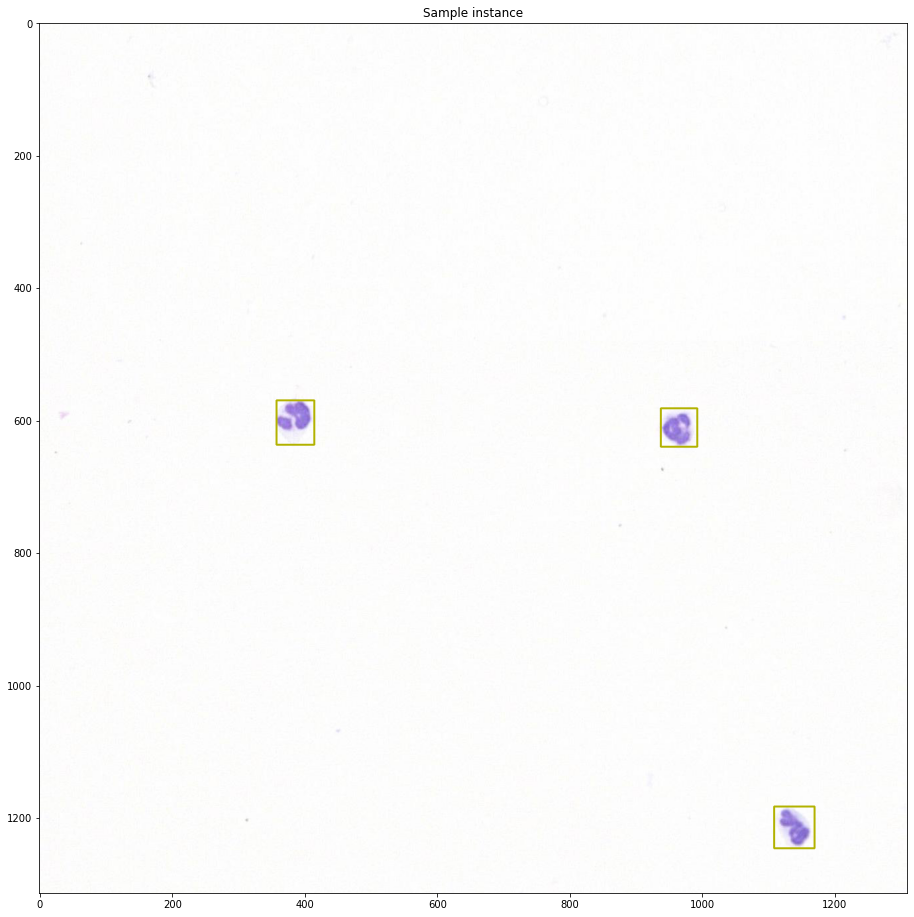

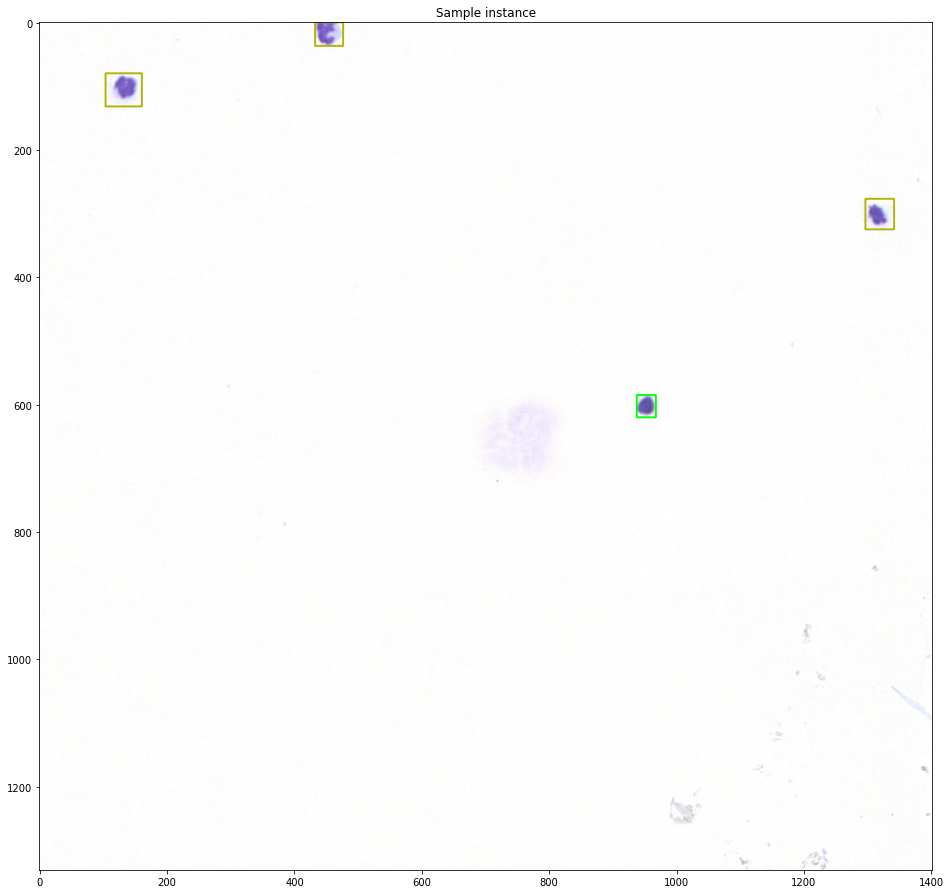

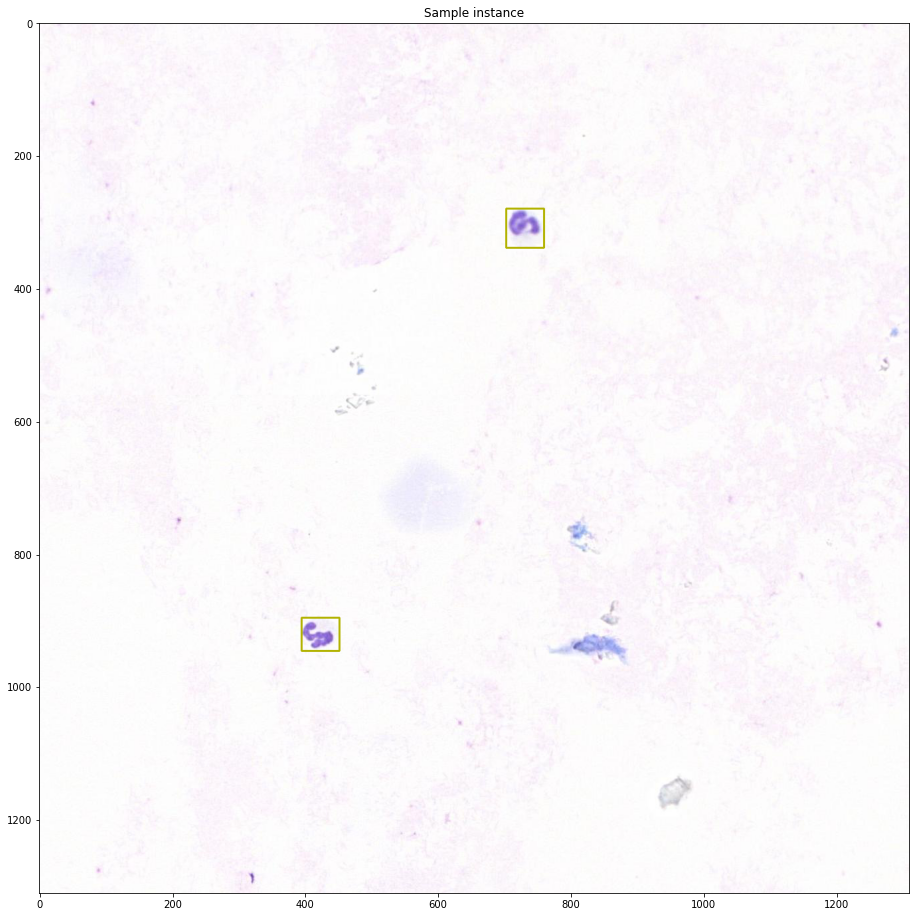

In [21]:
TARGET_INDICES = range(3)

for idx in TARGET_INDICES:
    target_img = test_ds.get_image(idx)
    target_gt_box_set = test_ds.get_gt_box_set(idx)

    labeled_img = get_labeled_image(target_img, target_gt_box_set)

    plt.figure(figsize=(16, 16))
    plt.imshow((labeled_img * 255).astype(np.uint8))
    plt.title('Sample instance')
    plt.show()

# Hyper-parameters for Faster R-CNN training

In [23]:
IS_TRAINING = True

MAX_BATCHES = 30001  # number of batch iteration
LR = 0.001  # learning rate
MM = 0.9    # momentum

ANCHOR_BASE_SIZE = 16
ANCHOR_SCALES = [3, 6]
ANCHOR_RATIOS = [0.67, 1, 1.5]

K = len(ANCHOR_SCALES) * len(ANCHOR_RATIOS)

NMS_TOP_K = 2000  # for training
NMS_IOU_THRES = 0.7

ROI_POOL_SIZE = 7
RPN_CHANNELS = 512
TOTAL_STRIDE = 16

RPN_POS_RATIO = 0.5
RPN_BATCH_SIZE = 128
RPN_NEG_THRES = 0.3
RPN_POS_THRES = 0.7

FRCNN_POS_RATIO = 0.25
FRCNN_BATCH_SIZE = 128
FRCNN_POS_THRES = 0.7
FRCNN_NEG_THRES = 0.5

LOG_DIR = 'exp'
EXP_NAME = 'pilot'

LOG_PERIOD = 100
SAVE_PERIOD = 1000

# Define functions

## Anchor box functions

In [24]:
def _to_whxy_format(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr


def _to_anchor_format(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center (x_ctr, y_ctr), output a set of anchors (windows).
    """
    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack(
        (x_ctr - 0.5 * (ws - 1), y_ctr - 0.5 * (hs - 1), x_ctr + 0.5 * (ws - 1), y_ctr + 0.5 * (hs - 1))
    )
    return anchors


def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """
    scales = np.array(scales)
    w, h, x_ctr, y_ctr = _to_whxy_format(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _to_anchor_format(ws, hs, x_ctr, y_ctr)
    return anchors


def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """
    ratios = np.array(ratios)
    w, h, x_ctr, y_ctr = _to_whxy_format(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _to_anchor_format(ws, hs, x_ctr, y_ctr)
    return anchors


def generate_anchor_boxes(input_image, total_stride, anchor_base_size, anchor_scales, anchor_ratios):
    image_shape = tf.shape(input_image)
    
    # Calculate the number of grid cells.
    num_grids_h = tf.to_int32(tf.ceil(image_shape[1] / np.float32(total_stride)))
    num_grids_w = tf.to_int32(tf.ceil(image_shape[2] / np.float32(total_stride)))
    num_grids = num_grids_h * num_grids_w
    
    t_checkup['num_grids_h'] = num_grids_h
    t_checkup['num_grids_w'] = num_grids_w
    t_checkup['num_grids'] = num_grids
    
    # Prepare a shift expansion.
    shift_x, shift_y = tf.meshgrid(
        tf.range(num_grids_w) * total_stride, tf.range(num_grids_h) * total_stride
    )
    shift_x, shift_y = tf.reshape(shift_x, (-1,)), tf.reshape(shift_y, (-1,))  # [num_grids], [num_grids]
    shifts = tf.transpose(tf.stack([shift_x, shift_y, shift_x, shift_y]))  # [num_grids, 4]
    shifts = tf.transpose(tf.reshape(shifts, shape=[1, num_grids, 4]), perm=(1, 0, 2))  # [num_grids, 1, 4]
    
    # Create a base anchor.
    base_anchor = np.array([0, 0, anchor_base_size - 1, anchor_base_size - 1])  # [4]
    
    # Expand anchors by ratios.
    anchors = _ratio_enum(base_anchor, anchor_ratios)  # [num_ratios, 4]
        
    # Expand anchors by scales.
    anchors = np.vstack(  # [num_ratios * num_scales, 4]
        [_scale_enum(anchors[i, :], anchor_scales) for i in range(anchors.shape[0])]
    )
    
    # Expand anchors by shifts.
    num_anchors_per_grid = anchors.shape[0]
    anchors = tf.constant(anchors.reshape((1, num_anchors_per_grid, 4)), dtype=tf.int32)  # [1, num_anchors_per_grid, 4]
    
    shift_x, shift_y = tf.meshgrid(
        tf.range(num_grids_w) * total_stride, tf.range(num_grids_h) * total_stride
    )
    shift_x, shift_y = tf.reshape(shift_x, (-1,)), tf.reshape(shift_y, (-1,))  # [num_grids], [num_grids]
    shifts = tf.transpose(tf.stack([shift_x, shift_y, shift_x, shift_y]))  # [num_grids, 4]
    shifts = tf.transpose(tf.reshape(shifts, shape=[1, num_grids, 4]), perm=(1, 0, 2))  # [num_grids, 1, 4]
    
    anchors = tf.add(anchors, shifts)  # [num_grids, num_anchors_per_grid, 4]
    anchors = tf.reshape(anchors, (-1, 4))  # [num_anchors, 4], where num_grids * num_anchors_per_grid = num_anchors
    
    return tf.cast(anchors, dtype=tf.float32)


## Bounding box functions

In [25]:
# Fot test only. 
# Use cython's bbox_overlaps instead!
def my_bbox_overlaps(boxes1, boxes2):
    """Compute the IOUs between the two sets of boxes.
    
    Args:
        boxes1 (numpy.ndarray): [num_boxes1, 4]-D array
        boxes2 (numpy.ndarray): [num_boxes2, 4]-D array
    
    Each of a box comprises 4 coordinate values in [xmin, ymin, xmax, ymax] order.
        
    Returns:
        overlaps (numpy.ndarray): [num_boxes1, num_boxes2]-D array, which is the distance matrix of the two sets of boxes
    """
    # Compute the areas of `boxes1` and `boxes2`.
    area1 = (boxes1[:, 2] - boxes1[:, 0] + 1) * (boxes1[:, 3] - boxes1[:, 1] + 1)  # [num_boxes1]
    area2 = (boxes2[:, 2] - boxes2[:, 0] + 1) * (boxes2[:, 3] - boxes2[:, 1] + 1)  # [num_boxes2]
    
    # Compute the areas of the intersections.
    intersection_h = np.maximum(
        (np.minimum(np.expand_dims(boxes1[:, 3], axis=1), boxes2[:, 3]) -
         np.maximum(np.expand_dims(boxes1[:, 1], axis=1), boxes2[:, 1]) + 1),
        0
    )  # [num_boxes1, num_boxes2]-D
    intersection_w = np.maximum(
        (np.minimum(np.expand_dims(boxes1[:, 2], axis=1), boxes2[:, 2]) -
         np.maximum(np.expand_dims(boxes1[:, 0], axis=1), boxes2[:, 0]) + 1),
        0
    )  # [num_boxes1, num_boxes2]-D
    intersection = intersection_h * intersection_w  # [num_boxes1, num_boxes2]-D

    # Compute the areas of the unions.
    union = np.maximum(
        np.expand_dims(area1, 1) + area2 - intersection,
        np.finfo(float).eps
    )
    
    # Compute IOU values.
    iou = intersection / union

    return iou


def compute_bbox_deltas(src_bboxes, dst_bboxes):
    src_widths = src_bboxes[:, 2] - src_bboxes[:, 0] + 1.0
    src_heights = src_bboxes[:, 3] - src_bboxes[:, 1] + 1.0
    src_ctr_x = src_bboxes[:, 0] + 0.5 * src_widths
    src_ctr_y = src_bboxes[:, 1] + 0.5 * src_heights

    dst_widths = dst_bboxes[:, 2] - dst_bboxes[:, 0] + 1.0
    dst_heights = dst_bboxes[:, 3] - dst_bboxes[:, 1] + 1.0
    dst_ctr_x = dst_bboxes[:, 0] + 0.5 * dst_widths
    dst_ctr_y = dst_bboxes[:, 1] + 0.5 * dst_heights

    targets_dx = (dst_ctr_x - src_ctr_x) / src_widths
    targets_dy = (dst_ctr_y - src_ctr_y) / src_heights
    targets_dw = np.log(dst_widths / src_widths)
    targets_dh = np.log(dst_heights / src_heights)

    targets = np.vstack((targets_dx, targets_dy, targets_dw, targets_dh)).transpose()
    return targets


def _unmap(data, count, indices, fill=0):
    """Unmap a subset of item (data) back to the original set of items (of size count)
    """
    if len(data.shape) == 1:
        ret = np.empty((count,), dtype=np.float32)
        ret.fill(fill)
        ret[indices] = data
    else:
        ret = np.empty((count,) + data.shape[1:], dtype=np.float32)
        ret.fill(fill)
        ret[indices, :] = data
    return ret


def transform_bboxes(boxes, deltas):
    """
    Args:
        boxes: [num_boxes, 4], (xmin, ymin, xmax, ymax) formed
        deltas: [num_boxes, 4], (tx, ty, tw, th)
    """
    boxes = tf.cast(boxes, deltas.dtype)
    
    # Compute size and center coordinates of the boxex.
    widths = tf.subtract(boxes[:, 2], boxes[:, 0]) + 1.0
    heights = tf.subtract(boxes[:, 3], boxes[:, 1]) + 1.0
    ctr_x = tf.add(boxes[:, 0], widths * 0.5)
    ctr_y = tf.add(boxes[:, 1], heights * 0.5)

    tx, ty, tw, th = deltas[:, 0], deltas[:, 1], deltas[:, 2], deltas[:, 3]

    transformed_ctr_x = tf.add(tf.multiply(tx, widths), ctr_x)
    transformed_ctr_y = tf.add(tf.multiply(ty, heights), ctr_y)
    transformed_w = tf.multiply(tf.exp(tw), widths)
    transformed_h = tf.multiply(tf.exp(th), heights)

    transformed_xmin = tf.subtract(transformed_ctr_x, transformed_w * 0.5)
    transformed_ymin = tf.subtract(transformed_ctr_y, transformed_h * 0.5)
    transformed_xmax = tf.add(transformed_ctr_x, transformed_w * 0.5)
    transformed_ymax = tf.add(transformed_ctr_y, transformed_h * 0.5)

    return tf.stack([transformed_xmin, transformed_ymin, transformed_xmax, transformed_ymax], axis=1)


def clip_bboxes(boxes, img_shape):
    """
    Args:
        boxes: [n_boxes, 4]
        img_shape: [2]
    """
    img_shape = tf.to_float(img_shape)
    b0 = tf.maximum(tf.minimum(boxes[:, 0], img_shape[2] - 1), 0)
    b1 = tf.maximum(tf.minimum(boxes[:, 1], img_shape[1] - 1), 0)
    b2 = tf.maximum(tf.minimum(boxes[:, 2], img_shape[2] - 1), 0)
    b3 = tf.maximum(tf.minimum(boxes[:, 3], img_shape[1] - 1), 0)
    
    return tf.stack([b0, b1, b2, b3], axis=1)


def transform_bboxes_np(boxes, deltas):
    """
    Args:
        boxes: [num_boxes, 4], (xmin, ymin, xmax, ymax) formed
        deltas: [num_boxes, 4], (tx, ty, tw, th)
    """
    # Compute size and center coordinates of the boxex.
    widths = boxes[:, 2] -  boxes[:, 0] + 1.0
    heights = boxes[:, 3] - boxes[:, 1] + 1.0
    ctr_x = boxes[:, 0] + widths * 0.5
    ctr_y = boxes[:, 1] + heights * 0.5

    tx, ty, tw, th = deltas[:, 0], deltas[:, 1], deltas[:, 2], deltas[:, 3]

    transformed_ctr_x = (tx * widths) + ctr_x
    transformed_ctr_y = (ty * heights) + ctr_y
    transformed_w = np.exp(tw) * widths
    transformed_h = np.exp(th) * heights

    transformed_xmin = transformed_ctr_x - transformed_w * 0.5
    transformed_ymin = transformed_ctr_y - transformed_h * 0.5
    transformed_xmax = transformed_ctr_x + transformed_w * 0.5
    transformed_ymax = transformed_ctr_y + transformed_h * 0.5

    return np.stack([transformed_xmin, transformed_ymin, transformed_xmax, transformed_ymax], axis=1)


def clip_bboxes_np(boxes, img_shape):
    b0 = np.maximum(np.minimum(boxes[:, 0], img_shape[1] - 1), 0)
    b1 = np.maximum(np.minimum(boxes[:, 1], img_shape[0] - 1), 0)
    b2 = np.maximum(np.minimum(boxes[:, 2], img_shape[1] - 1), 0)
    b3 = np.maximum(np.minimum(boxes[:, 3], img_shape[0] - 1), 0)
    
    return np.stack([b0, b1, b2, b3], axis=1)


def nms(boxes, rpn_cls_probs, top_k, iou_thres):
    obj_scores = tf.reshape(tf.transpose(tf.reshape(rpn_cls_probs, (-1, K, 2)), (0, 2, 1)), tf.shape(rpn_cls_probs))[..., K:]
    nms_indices = tf.image.non_max_suppression(
        boxes, tf.reshape(obj_scores, (-1,)), max_output_size=top_k, iou_threshold=iou_thres
    )
    boxes_alive = tf.gather(boxes, nms_indices)
    scores_alive = tf.gather(tf.reshape(obj_scores, (-1,)), nms_indices)
    
    return boxes_alive, scores_alive


def cpu_nms(boxes, iou_thres=0.5):
    x1 = boxes[..., 0]
    y1 = boxes[..., 1]
    x2 = boxes[..., 2]
    y2 = boxes[..., 3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    scores = boxes[..., 4]

    keep = []
    order = scores.argsort()[::-1]

    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= iou_thres)[0]
        order = order[inds + 1]

    return keep


## Backbone CNN (VGG-16) defining function

In [26]:
def conv_layers(input_image, is_training):
    """
    Args:
        image (np.ndarray): [1, image_height, image_width, image_channel]
        is_training (bool)
    
    Returns:
        conv_feats (Tensor): [1, height/stride, width/stride, depth]
    """
    net = slim.repeat(input_image, 2, slim.conv2d, 64, [3, 3], trainable=is_training, scope='conv1')
    net = slim.max_pool2d(net, [2, 2], padding='SAME', scope='pool1')  # total stride: 2
    net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], trainable=is_training, scope='conv2')
    net = slim.max_pool2d(net, [2, 2], padding='SAME', scope='pool2')  # total stride: 4
    net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], trainable=is_training, scope='conv3')
    net = slim.max_pool2d(net, [2, 2], padding='SAME', scope='pool3')  # total stride: 8
    net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], trainable=is_training, scope='conv4')
    net = slim.max_pool2d(net, [2, 2], padding='SAME', scope='pool4')  # total stride: 16
    net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], trainable=is_training, scope='conv5')
    conv_feats = net
    return conv_feats


## RPN layer defining functions

In [27]:
def rpn_intermediate_layer(conv_feats, rpn_channels, is_training):
    rpn_intermediate = slim.conv2d(conv_feats, rpn_channels, [3, 3], trainable=is_training)
    return rpn_intermediate


def rpn_classification_layer(rpn_intermediate, is_training):
    cls_scores = slim.conv2d(  # [H/16, W/16, 2 * num_anchors_per_grid]
        rpn_intermediate,
        K * 2, [1, 1], trainable=is_training,
        weights_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
        weights_regularizer=tf.contrib.layers.l2_regularizer(0.0001),
        padding='VALID', activation_fn=None
    )
    cls_probs = tf.reshape(tf.nn.softmax(tf.reshape(cls_scores, (-1, 2))), tf.shape(cls_scores))
    cls_preds = tf.argmax(tf.reshape(cls_probs, (-1, 2)), axis=1)
    return cls_scores, cls_probs, cls_preds


def rpn_regression_layer(rpn_intermediate, is_training):
    bbox_params = slim.conv2d(
        rpn_intermediate,
        K * 4, [1, 1], trainable=is_training,
        weights_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
        weights_regularizer=tf.contrib.layers.l2_regularizer(0.0001),
        padding='VALID', activation_fn=None
    )
    return bbox_params


## Detection layer (Fast R-CNN) defining functions

In [28]:
def roi_pooling_layer(conv_feats, proposal_boxes, pool_size):
    # Get normalized ROI coordinates.
    ceiled_img_h = tf.to_float(tf.shape(t_conv_feats)[1]) * np.float32(TOTAL_STRIDE)
    ceiled_img_w = tf.to_float(tf.shape(t_conv_feats)[2]) * np.float32(TOTAL_STRIDE)                
    xmin = proposal_boxes[:, 0:1] / ceiled_img_w
    ymin = proposal_boxes[:, 1:2] / ceiled_img_h
    xmax = proposal_boxes[:, 2:3] / ceiled_img_w
    ymax = proposal_boxes[:, 3:4] / ceiled_img_h
    normalized_boxes = tf.concat([ymin, xmin, ymax, xmax], axis=1)  # [num_proposal_boxes, 4]

    batch_indices = tf.zeros((tf.shape(normalized_boxes)[0],), dtype=tf.int32)

    pre_pool_size = pool_size * 2
    cropped_feats = tf.image.crop_and_resize(
        conv_feats, normalized_boxes, batch_indices, [pre_pool_size, pre_pool_size], name='roi_pooled_feats'
    )
    pooled_feats = slim.max_pool2d(cropped_feats, [2, 2], padding='SAME')
    
    return pooled_feats


def fc_layers(roi_pooled_feats, is_training):
    """
    Args:
        poold_rois: [num_rois, roi_height, roi_width, image_channel]
        is_training (bool)
        
    Returns:
        fc_feats (Tensor): [num_rois, depth]
    """
    pooled_rois_flat = slim.flatten(roi_pooled_feats, scope='pooled_rois_flat')
    fc6 = slim.fully_connected(pooled_rois_flat, 4096, scope='fc6', reuse=tf.AUTO_REUSE)
    dropout6 = slim.dropout(fc6, keep_prob=0.5, is_training=is_training, scope='dropout6')
    fc7 = slim.fully_connected(fc6, 4096, scope='fc7', reuse=tf.AUTO_REUSE)
    dropout7 = slim.dropout(fc7, keep_prob=0.5, is_training=is_training, scope='dropout7')
    fc_feats = dropout7

    return fc_feats


def faster_rcnn_classification_layer(fc_feats, num_obj_classes, is_training):
    num_classes = num_obj_classes + 1
    
    cls_scores = slim.fully_connected(
        fc_feats, num_classes,
        weights_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.01),
        trainable=is_training, activation_fn=None, scope='cls_scores', reuse=tf.AUTO_REUSE
    )
    cls_probs = tf.nn.softmax(cls_scores)
    cls_preds = tf.argmax(cls_probs, axis=1)
    
    return cls_scores, cls_probs, cls_preds


def faster_rcnn_regression_layer(fc_feats, num_obj_classes, is_training):
    num_classes = num_obj_classes + 1
    
    bbox_params = slim.fully_connected(
        fc_feats, num_classes * 4,
        weights_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.001),
        trainable=is_training, activation_fn=None, scope='bbox_params', reuse=tf.AUTO_REUSE
    )
    
    return bbox_params


## Sampling & targeting layer defining functions

In [29]:
def anchor_target_layer(rpn_cls_scores, anchor_boxes, gt_boxes, image_size):
    gt_boxes = gt_boxes[0]
    num_grids_h, num_grids_w = rpn_cls_scores.shape[1:3]

    # Only keep anchor boxes inside the image border.
    inds_inside = np.where(
        (anchor_boxes[:, 0] >= 0) & (anchor_boxes[:, 1] >= 0) & (anchor_boxes[:, 2] < image_size[1]) & (anchor_boxes[:, 3] < image_size[0])
    )[0]
    anchor_boxes_inside = anchor_boxes[inds_inside, :]
    
    # Create labels. (1: Positive, 0: Negative, -1: Ignore)
    labels_inside = np.empty((len(inds_inside),), dtype=np.float32)  # [num_inside_anchor_boxes]
    labels_inside.fill(-1)  # Default to be ignored

    # Compute the IOU matrix (distance matrix) between the anchor boxes and GT boxes.
    overlaps = bbox_overlaps(  # [num_anchor_boxes, num_gt_boxes]-D matrix
        np.ascontiguousarray(anchor_boxes_inside, dtype=np.float64),
        np.ascontiguousarray(gt_boxes, dtype=np.float64)
    )

    # Find the argmax and max for the anchor boxes.
    argmax_overlaps = overlaps.argmax(axis=1)  # [num_anchor_boxes]
    max_overlaps = overlaps.max(axis=1)  # [num_anchor_boxes]

    # Find the argmax and max for the GT boxes.
    gt_argmax_overlaps = overlaps.argmax(axis=0)  # [num_gt_boxes]
    gt_max_overlaps = overlaps.max(axis=0)  # [num_gt_boxes]

    # Assign labels to anchor boxes.
    # Positive: 1, Negative: 0, Ignored: -1
    labels_inside[max_overlaps < RPN_NEG_THRES] = 0
    labels_inside[max_overlaps >= RPN_POS_THRES] = 1

    # Assign positive labels to anchor boxes which best matches to any GT boxes.
    labels_inside[gt_argmax_overlaps] = 1

    # Subsample the positive samples if we have too many.
    num_pos_limit = int(RPN_POS_RATIO * RPN_BATCH_SIZE)
    inds_pos = np.where(labels_inside == 1)[0]
    if len(inds_pos) > num_pos_limit:
        inds_drop_out = npr.choice(inds_pos, size=(len(inds_pos) - num_pos_limit), replace=False)
        labels_inside[inds_drop_out] = -1

    # Subsampe the negative samples if we have too many.
    num_neg_limit = RPN_BATCH_SIZE - np.sum(labels_inside == 1)
    inds_neg = np.where(labels_inside == 0)[0]
    if len(inds_neg) > num_neg_limit:
        inds_drop_out = npr.choice(inds_neg, size=(len(inds_neg) - num_neg_limit), replace=False)
        labels_inside[inds_drop_out] = -1

    # Compute bbox deltas of all the inside anchor boxes.
    bbox_targets_inside = compute_bbox_deltas(anchor_boxes_inside, gt_boxes[argmax_overlaps, :])

    # Map up to original set of anchor boxes (only inside anchor boxes -> all anchor boxes)
    num_anchor_boxes = anchor_boxes.shape[0]
    labels = _unmap(labels_inside, num_anchor_boxes, inds_inside, fill=-1)
    bbox_targets = _unmap(bbox_targets_inside, num_anchor_boxes, inds_inside, fill=0)

    # Reshape tensors into a grid cell form.
    labels = labels.reshape((1, num_grids_h, num_grids_w, K))
    bbox_targets = bbox_targets.reshape((1, num_grids_h, num_grids_w, K * 4))
    
    return labels, bbox_targets


def proposal_target_layer(proposal_boxes, proposal_scores, gt_boxes, num_obj_classes):
    """
    Assign object detection proposals to ground-truth targets.
    Produces proposal classification labels and bounding-box regression targets.
    Args:
        proposal_boxes: [num_proposal_boxes, 4]
        proposal_scores: [num_proposal_boxes, 1]
    """
    num_classes = num_obj_classes + 1
    gt_boxes = gt_boxes[0]
    
    overlaps = bbox_overlaps(
        np.ascontiguousarray(proposal_boxes, dtype=np.float64),
        np.ascontiguousarray(gt_boxes, dtype=np.float64)
    )
    
    argmax_overlaps = overlaps.argmax(axis=1)  # [num_proposal_boxes]
    max_overlaps = overlaps.max(axis=1)  # [num_proposal_boxes]
    
    # Sample positive and negative samples to compose a batch.
    inds_pos = np.where(max_overlaps >= FRCNN_POS_THRES)[0]
    inds_neg = np.where(max_overlaps < FRCNN_NEG_THRES)[0]
    
    if len(inds_pos) == 0 and len(inds_neg) == 0:
        raise Exception('Neither positive and negative samples exists.')
        
    num_pos_limit = int(FRCNN_POS_RATIO * FRCNN_BATCH_SIZE)
    if len(inds_pos) > num_pos_limit:
        inds_pos = npr.choice(inds_pos, num_pos_limit, replace=False)
    
    num_neg = FRCNN_BATCH_SIZE - len(inds_pos)
    if len(inds_neg) > num_neg:
        inds_neg = npr.choice(inds_neg, num_neg, replace=False)
    elif len(inds_neg) < num_neg:
        inds_neg = npr.choice(inds_neg, num_neg, replace=True)

    # Collect the sampled proposal boxes.
    inds_sampled = np.append(inds_pos, inds_neg)
    sampled_proposal_boxes = proposal_boxes[inds_sampled]
    sampled_proposal_scores = proposal_scores[inds_sampled]
    
    # Compose classification labels and bounding box regression targets.
    labels = gt_boxes[argmax_overlaps[inds_sampled], 4] + 1
    labels[len(inds_pos):] = 0  # Set negative samples' label to 0(background).
    
    # DEBUG
    # print('IOUs of proposal boxes:\n{}'.format(np.sort(max_overlaps[inds_sampled])[::-1][:5]))
    # print('inds_pos: {}, inds_neg: {}'.format(len(inds_pos), len(inds_neg)))
    
    bbox_targets = compute_bbox_deltas(proposal_boxes[inds_sampled], gt_boxes[argmax_overlaps[inds_sampled]])
    
    return sampled_proposal_boxes, sampled_proposal_scores, labels, bbox_targets


## Loss function

In [30]:
def compose_loss_functions(
    rpn_cls_scores, rpn_labels, rpn_bbox_params, rpn_bbox_targets,
    frcnn_cls_scores, frcnn_labels, frcnn_bbox_params, frcnn_bbox_targets
):
    rpn_labels = tf.reshape(rpn_labels, (-1,))
    inds_selected = tf.reshape(tf.where(tf.not_equal(rpn_labels, -1)), (-1,))
    inds_positive = tf.reshape(tf.where(tf.equal(rpn_labels, 1)), (-1,))
    rpn_cls_scores = tf.gather(tf.reshape(rpn_cls_scores, (-1, 2)), inds_selected)
    rpn_labels = tf.gather(rpn_labels, inds_selected)
    rpn_cls_loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits=rpn_cls_scores, labels=tf.cast(rpn_labels, tf.int64))
    )
    
    rpn_bbox_params = tf.gather(tf.reshape(rpn_bbox_params, (-1, 4)), inds_positive)
    rpn_bbox_targets = tf.gather(tf.reshape(rpn_bbox_targets, (-1, 4)), inds_positive)

    loss_checkup['rpn_bbox_params'] = rpn_bbox_params
    loss_checkup['rpn_bbox_targets'] = rpn_bbox_targets
    rpn_huber_loss = tf.losses.huber_loss(rpn_bbox_targets, rpn_bbox_params, reduction=tf.losses.Reduction.NONE)
    loss_checkup['rpn_huber_loss'] = rpn_huber_loss
    rpn_reg_loss = tf.reduce_mean(
        tf.reduce_sum(rpn_huber_loss, axis=1)
    )
    
    frcnn_cls_loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits=frcnn_cls_scores, labels=tf.cast(frcnn_labels, tf.int64))
    )
    
    inds_fg = tf.reshape(tf.where(tf.not_equal(frcnn_labels, 0)), (-1,))
    loss_checkup['inds_fg'] = inds_fg
    
    frcnn_bbox_params = tf.reshape(frcnn_bbox_params, (FRCNN_BATCH_SIZE, -1, 4))  # [batch_size, num_classes, 4]
    frcnn_bbox_targets = tf.reshape(frcnn_bbox_targets, (FRCNN_BATCH_SIZE, 1, 4))  # [batch_size, 1, 4]
    frcnn_reg_mask = tf.one_hot(tf.cast(frcnn_labels, tf.int64), tf.shape(frcnn_bbox_params)[1])
    frcnn_reg_mask = tf.expand_dims(frcnn_reg_mask, axis=2)
    loss_checkup['frcnn_bbox_params'] = frcnn_bbox_params
    loss_checkup['frcnn_bbox_targets'] = frcnn_bbox_targets
    loss_checkup['frcnn_reg_mask'] = frcnn_reg_mask
    
    frcnn_huber_loss = tf.losses.huber_loss(frcnn_bbox_targets, frcnn_bbox_params, reduction=tf.losses.Reduction.NONE)
    loss_checkup['frcnn_huber_loss'] = frcnn_huber_loss
    frcnn_huber_loss_masked = frcnn_reg_mask * frcnn_huber_loss
    loss_checkup['frcnn_huber_loss_masked'] = frcnn_huber_loss_masked
    frcnn_reg_loss = tf.reduce_mean(
        tf.reduce_sum(
            frcnn_huber_loss_masked[:, 1:, :], axis=[1, 2]
        )
    )

    total_loss = rpn_cls_loss + rpn_reg_loss + frcnn_cls_loss + frcnn_reg_loss
    
    return rpn_cls_loss, rpn_reg_loss, frcnn_cls_loss, frcnn_reg_loss, total_loss


# Build a tensorflow model

## placeholder

In [31]:
t_input = {
    'image': tf.placeholder(tf.float32, shape=(1, None, None, 3)),  # [height, width, channel]
    'gt_box_set': tf.placeholder(tf.float32, shape=[1, None, 5])  # [[xmin, ymin, xmax, ymax, cls_idx], ...]
}

t_checkup = {}
loss_checkup = {}

## CNN feature extraction

In [32]:
# final feature map of CNN
t_conv_feats = conv_layers(t_input['image'], IS_TRAINING)


Instructions for updating:
Please use `layer.__call__` method instead.


## RPN classification & regression

In [33]:
t_rpn_intermediate = rpn_intermediate_layer(t_conv_feats, RPN_CHANNELS, IS_TRAINING)

t_rpn_cls_scores, t_rpn_cls_probs, t_rpn_cls_preds = rpn_classification_layer(t_rpn_intermediate, IS_TRAINING)
t_rpn_bbox_params = rpn_regression_layer(t_rpn_intermediate, IS_TRAINING)

## proposal box tensor (anchor + bbox_param)

In [34]:
# anchor boxes
t_anchor_boxes = generate_anchor_boxes(t_input['image'], TOTAL_STRIDE, ANCHOR_BASE_SIZE, ANCHOR_SCALES, ANCHOR_RATIOS)

# transform anchor boxes wrt bbox params
t_transformed_anchor_boxes = transform_bboxes(t_anchor_boxes, tf.reshape(t_rpn_bbox_params, (-1, 4)))
t_clipped_anchor_boxes = clip_bboxes(t_transformed_anchor_boxes, tf.shape(t_input['image']))

# region proposal boxes
t_proposal_boxes, t_proposal_scores = nms(t_clipped_anchor_boxes, t_rpn_cls_probs, NMS_TOP_K, NMS_IOU_THRES)

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.


## anchor box targeting layer (for training)

In [35]:
t_rpn_labels, t_rpn_bbox_targets = tf.py_func(
    anchor_target_layer,
    [t_rpn_cls_scores, t_anchor_boxes, t_input['gt_box_set'], tf.shape(t_input['image'])[1:3]],
    [tf.float32, tf.float32],
    name='anchor_target'
)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


## proposal box targeting layer (for training)

In [36]:
t_sampled_proposal_boxes, t_sampled_proposal_scores, t_frcnn_labels, t_frcnn_bbox_targets = tf.py_func(
    proposal_target_layer,
    [t_proposal_boxes, t_proposal_scores, t_input['gt_box_set'], num_obj_classes],
    [tf.float32, tf.float32, tf.float32, tf.float32],
    name='proposal_target'
)

## ROI pooling layer (using sampled proposal boxes in training mode)

In [37]:
# for training
t_roi_pooled_feats = roi_pooling_layer(t_conv_feats, t_sampled_proposal_boxes, ROI_POOL_SIZE)


Instructions for updating:
box_ind is deprecated, use box_indices instead


## detection (Fast R-CNN) classification & regression

In [38]:
t_fc_feats = fc_layers(t_roi_pooled_feats, IS_TRAINING)

t_frcnn_cls_scores, t_frcnn_cls_probs, t_frcnn_cls_preds = faster_rcnn_classification_layer(t_fc_feats, num_obj_classes, IS_TRAINING)
t_frcnn_bbox_params = faster_rcnn_regression_layer(t_fc_feats, num_obj_classes, IS_TRAINING)

Instructions for updating:
Use keras.layers.flatten instead.


## loss function

In [39]:
t_rpn_cls_loss, t_rpn_reg_loss, t_frcnn_cls_loss, t_frcnn_reg_loss, t_total_loss = compose_loss_functions(
    t_rpn_cls_scores, t_rpn_labels, t_rpn_bbox_params,  t_rpn_bbox_targets,
    t_frcnn_cls_scores, t_frcnn_labels, t_frcnn_bbox_params, t_frcnn_bbox_targets
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## optimizer & training operation

In [40]:
# momentum optimizer
# optimizer = tf.train.AdamOptimizer(LR, MM)
optimizer = tf.train.MomentumOptimizer(LR, MM)

train_op = optimizer.minimize(t_total_loss)


# Create a tensorflow session

In [41]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# Check the model with a sample data

## check box functions (in general)

In [42]:
boxes1 = np.array([[10, 10, 50, 50], [80, 80, 120, 120]])
boxes2 = np.array([[30, 10, 70, 50], [80, 80, 120, 120], [80, 80, 120, 160]])

print('Custom bbox_overlaps:\n{}'.format(my_bbox_overlaps(boxes1, boxes2)))
print('Cython bbox_overlaps:\n{}'.format(bbox_overlaps(np.asarray(boxes1, np.float64), np.asarray(boxes2, np.float64))))

Custom bbox_overlaps:
[[0.3442623  0.         0.        ]
 [0.         1.         0.50617284]]
Cython bbox_overlaps:
[[0.3442623  0.         0.        ]
 [0.         1.         0.50617284]]


In [43]:
boxes1 = np.array([[0, 0, 50, 50], [80, 80, 120, 160]])
boxes2 = np.array([[50, 50, 100, 150], [80, 80, 120, 160]])

deltas = compute_bbox_deltas(boxes1, boxes2)

print('Computed bbox params:\n{}'.format(deltas))

Computed bbox params:
[[0.98039216 1.47058824 0.         0.68329488]
 [0.         0.         0.         0.        ]]


## prepare a sample data batch

In [54]:
sample_batch_img, sample_batch_gt_box_set = test_ds.next_batch(1)

sample_feed_dict = {
    t_input['image']: sample_batch_img,
    t_input['gt_box_set']: sample_batch_gt_box_set
}

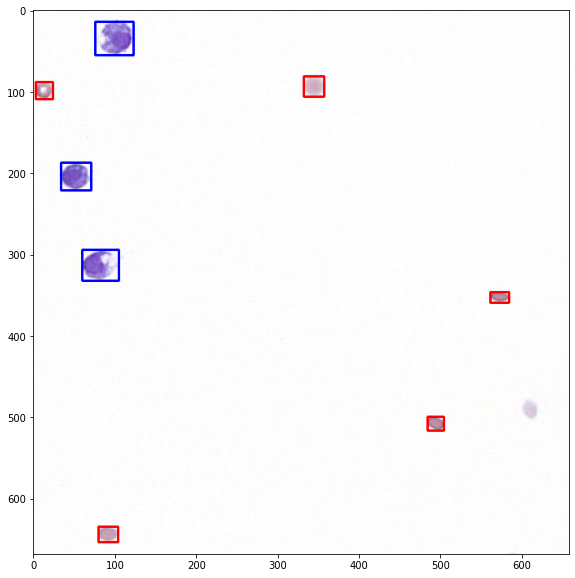

In [55]:
labeled_img = get_labeled_image(sample_batch_img[0], sample_batch_gt_box_set[0])
plt.figure(figsize=(10, 10))
plt.imshow((labeled_img * 255).astype(np.uint8))
plt.show()

## check and visualize anchor boxes

In [56]:
anchor_boxes, num_grids_h, num_grids_w, num_grids = sess.run(
    [t_anchor_boxes, t_checkup['num_grids_h'], t_checkup['num_grids_w'], t_checkup['num_grids']],
    feed_dict=sample_feed_dict
)

print('Image shape: {}'.format(sample_feed_dict[t_input['image']].shape))
print('Total stride: {}'.format(TOTAL_STRIDE))
print('Number of grids: {} x {} = {}'.format(num_grids_h, num_grids_w, num_grids))
print('Number of scale and ratio settings: {} x {} = {}'.format(len(ANCHOR_SCALES), len(ANCHOR_RATIOS), len(ANCHOR_SCALES) * len(ANCHOR_RATIOS)))
print('Number of anchors = {}'.format(anchor_boxes.shape[0]))

Image shape: (1, 668, 658, 3)
Total stride: 16
Number of grids: 42 x 42 = 1764
Number of scale and ratio settings: 2 x 3 = 6
Number of anchors = 10584


[Box # 0] Shape: ( 59,  37) -> Size:   2183,  Scale: 1.595
[Box # 1] Shape: (119,  77) -> Size:   9163,  Scale: 1.545
[Box # 2] Shape: ( 47,  47) -> Size:   2209,  Scale: 1.000
[Box # 3] Shape: ( 95,  95) -> Size:   9025,  Scale: 1.000
[Box # 4] Shape: ( 37,  59) -> Size:   2183,  Scale: 0.627
[Box # 5] Shape: ( 77, 119) -> Size:   9163,  Scale: 0.647


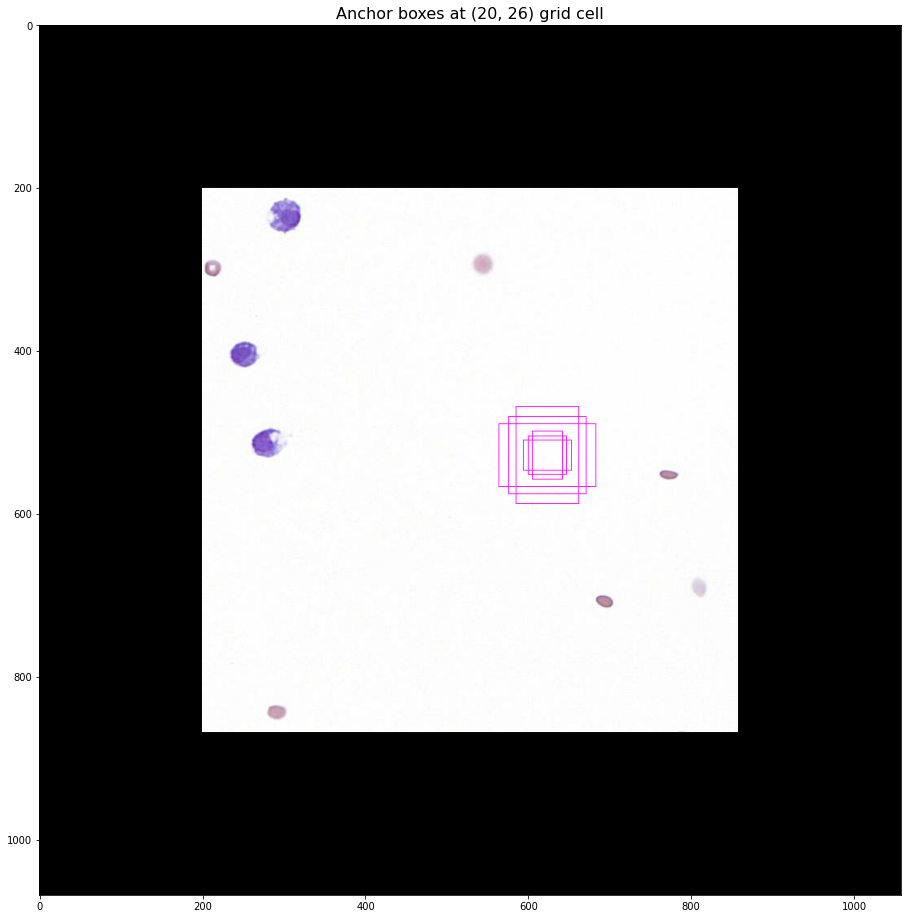

In [57]:
MARGIN = 200
GRID_IDX = (20, 26)
SHOW_ALL = False
PRINT_BOX_INFO = True

img_h, img_w = sample_batch_img.shape[1:3]

img_with_margin = np.zeros((img_h + MARGIN * 2, img_w + MARGIN * 2, 3)).astype(np.uint8)
img_with_margin[MARGIN:MARGIN + img_h, MARGIN:MARGIN + img_w, :] = np.asarray(sample_batch_img[0] * 255, dtype=np.uint8)

for idx, box in enumerate(anchor_boxes):
    if not SHOW_ALL and idx // K != GRID_IDX[0] * num_grids_w + GRID_IDX[1]:
        continue
    box = box + MARGIN
    cv2.rectangle(img_with_margin, (box[0], box[1]), (box[2], box[3]), color=(255, 0, 255), thickness=1)
    if PRINT_BOX_INFO:
        print('[Box # {}] Shape: ({:3}, {:3}) -> Size: {:6d},  Scale: {:.3f}'.format(
            idx % K, int(box[2] - box[0]), int(box[3] - box[1]),
            int((box[2] - box[0]) * (box[3] - box[1])), (box[2] - box[0]) / (box[3] - box[1])
        ))

plt.figure(figsize=(16, 16))
plt.title('Anchor boxes at {} grid cell'.format(GRID_IDX), fontdict={'fontsize': 16})
plt.imshow(img_with_margin)
plt.show()

## check CNN & RPN output shapes

In [58]:
print(t_conv_feats.shape)
print(t_rpn_intermediate.shape)
print(t_rpn_cls_scores.shape)
print(t_rpn_bbox_params.shape)

# for training
print(t_rpn_labels.shape)
print(t_rpn_bbox_targets.shape)

(1, ?, ?, 512)
(1, ?, ?, 512)
(1, ?, ?, 12)
(1, ?, ?, 24)
<unknown>
<unknown>


In [59]:
conv_feats, rpn_intermediate, rpn_cls_scores, rpn_cls_probs, rpn_cls_preds, rpn_bbox_params = sess.run(
    [t_conv_feats, t_rpn_intermediate, t_rpn_cls_scores, t_rpn_cls_probs, t_rpn_cls_preds, t_rpn_bbox_params],
    feed_dict=sample_feed_dict
)

print('Image shape: {}'.format(sample_feed_dict[t_input['image']].shape))
print('Total stride: {}'.format(TOTAL_STRIDE))
print('conv_feats shape: {}'.format(conv_feats.shape))
print('rpn_intermediate shape: {}'.format(rpn_intermediate.shape))

print('rpn_cls_scores shape: {}'.format(rpn_cls_scores.shape))
print('rpn_cls_probs shape: {}'.format(rpn_cls_probs.shape))
print('rpn_cls_preds shape: {}'.format(rpn_cls_preds.shape))
print('rpn_bbox_params shape: {}'.format(rpn_bbox_params.shape))

Image shape: (1, 668, 658, 3)
Total stride: 16
conv_feats shape: (1, 42, 42, 512)
rpn_intermediate shape: (1, 42, 42, 512)
rpn_cls_scores shape: (1, 42, 42, 12)
rpn_cls_probs shape: (1, 42, 42, 12)
rpn_cls_preds shape: (10584,)
rpn_bbox_params shape: (1, 42, 42, 24)


In [60]:
# for training
rpn_labels, rpn_bbox_targets = sess.run(
    [t_rpn_labels, t_rpn_bbox_targets], feed_dict=sample_feed_dict
)

print('rpn_labels: {}'.format(rpn_labels.shape))
print('rpn_bbox_targets: {}'.format(rpn_bbox_targets.shape))

print('Positive: {}'.format(np.count_nonzero(rpn_labels == 1)))
print('Negative: {}'.format(np.count_nonzero(rpn_labels == 0)))
print('Ignored: {}'.format(np.count_nonzero(rpn_labels == -1)))

print('Batch size: {}'.format(RPN_BATCH_SIZE))

rpn_labels: (1, 42, 42, 6)
rpn_bbox_targets: (1, 42, 42, 24)
Positive: 8
Negative: 120
Ignored: 10456
Batch size: 128


## check transformed proposal boxes

In [61]:
print(t_transformed_anchor_boxes.shape)
print(t_clipped_anchor_boxes.shape)

transformed_anchor_boxes, clipped_anchor_boxes = sess.run(
    [t_transformed_anchor_boxes, t_clipped_anchor_boxes], feed_dict=sample_feed_dict
)

print(transformed_anchor_boxes.shape)
print(clipped_anchor_boxes.shape)

(?, 4)
(?, 4)
(10584, 4)
(10584, 4)


In [62]:
ANCHOR_BOX_IDX = -1

print('anchor box: {}'.format(anchor_boxes[ANCHOR_BOX_IDX]))
print('bbox params: {}'.format(np.reshape(rpn_bbox_params, (-1, 4))[ANCHOR_BOX_IDX]))
print('transformed box: {}'.format(transformed_anchor_boxes[ANCHOR_BOX_IDX]))
print('image size: {}'.format(sample_batch_img.shape[1:3]))
print('clipped box: {}'.format(clipped_anchor_boxes[ANCHOR_BOX_IDX]))

anchor box: [625. 604. 702. 723.]
bbox params: [-1.9552735e-04  2.2080369e-05 -5.9627193e-05  3.3434771e-04]
transformed box: [624.98706 603.98254 702.9824  724.0227 ]
image size: (668, 658)
clipped box: [624.98706 603.98254 657.      667.     ]


In [63]:
print(t_proposal_boxes.shape)
print(t_proposal_scores.shape)

proposal_boxes, proposal_scores = sess.run([t_proposal_boxes, t_proposal_scores], feed_dict=sample_feed_dict)

print(proposal_boxes.shape)
print(proposal_scores.shape)

(?, 4)
(?,)
(2000, 4)
(2000,)


## check detection output shapes

In [64]:
# for training
print(t_sampled_proposal_boxes.shape)
print(t_sampled_proposal_scores.shape)

# for training
print(t_frcnn_labels.shape)
print(t_frcnn_bbox_targets.shape)

print(t_roi_pooled_feats.shape)
print(t_fc_feats.shape)
print(t_frcnn_cls_scores.shape)
print(t_frcnn_bbox_params.shape)

<unknown>
<unknown>
<unknown>
<unknown>
(?, 7, 7, 512)
(?, 4096)
(?, 5)
(?, 20)


In [65]:
# for training
sampled_proposal_boxes, sampled_proposal_scores, frcnn_labels, frcnn_bbox_targets = sess.run(
    [t_sampled_proposal_boxes, t_sampled_proposal_scores, t_frcnn_labels, t_frcnn_bbox_targets], feed_dict=sample_feed_dict
)

print('sampled_proposal_boxes: {}'.format(sampled_proposal_boxes.shape))
print('sampled_proposal_scores: {}'.format(sampled_proposal_scores.shape))

print('frcnn_labels: {}'.format(frcnn_labels.shape))
print('frcnn_bbox_targets: {}'.format(frcnn_bbox_targets.shape))

print('Positive: {}'.format(np.count_nonzero(frcnn_labels != 0)))
print('Negative: {}'.format(np.count_nonzero(frcnn_labels == 0)))

print('Batch size: {}'.format(FRCNN_BATCH_SIZE))

sampled_proposal_boxes: (128, 4)
sampled_proposal_scores: (128,)
frcnn_labels: (128,)
frcnn_bbox_targets: (128, 4)
Positive: 0
Negative: 128
Batch size: 128


In [66]:
roi_pooled_feats, fc_feats, frcnn_cls_scores, frcnn_cls_probs, frcnn_cls_preds, frcnn_bbox_params = sess.run(
    [t_roi_pooled_feats, t_fc_feats, t_frcnn_cls_scores, t_frcnn_cls_probs, t_frcnn_cls_preds, t_frcnn_bbox_params],
    feed_dict=sample_feed_dict
)

print('roi_pooled_feats shape: {}'.format(roi_pooled_feats.shape))
print('fc_feats shape: {}'.format(fc_feats.shape))

print('frcnn_cls_scores : {}'.format(frcnn_cls_scores.shape))
print('frcnn_cls_probs shape: {}'.format(frcnn_cls_probs.shape))
print('frcnn_cls_preds shape: {}'.format(frcnn_cls_preds.shape))
print('frcnn_bbox_params shape: {}'.format(frcnn_bbox_params.shape))

roi_pooled_feats shape: (128, 7, 7, 512)
fc_feats shape: (128, 4096)
frcnn_cls_scores : (128, 5)
frcnn_cls_probs shape: (128, 5)
frcnn_cls_preds shape: (128,)
frcnn_bbox_params shape: (128, 20)


## check loss values

In [67]:
rpn_cls_loss, rpn_reg_loss, frcnn_cls_loss, frcnn_reg_loss, total_loss = sess.run(
    [t_rpn_cls_loss, t_rpn_reg_loss, t_frcnn_cls_loss, t_frcnn_reg_loss, t_total_loss], feed_dict=sample_feed_dict
)

print('rpn_cls_loss', rpn_cls_loss)
print('rpn_reg_loss', rpn_reg_loss)
print('frcnn_cls_loss', frcnn_cls_loss)
print('frcnn_reg_loss', frcnn_reg_loss)

rpn_cls_loss 0.6934165
rpn_reg_loss 0.4856446
frcnn_cls_loss 1.6106657
frcnn_reg_loss 0.0


# Train the model

## for tensorboard logging

In [68]:
tf.summary.scalar('rpn_cls_loss', t_rpn_cls_loss)
tf.summary.scalar('rpn_reg_loss', t_rpn_reg_loss)
tf.summary.scalar('frcnn_cls_loss', t_frcnn_cls_loss)
tf.summary.scalar('frcnn_reg_loss', t_frcnn_reg_loss)
tf.summary.scalar('total_loss', t_total_loss)
merged_summaries = tf.summary.merge_all()

In [69]:
# Prepare the dedicated directory.
exp_dir = osp.join('.', LOG_DIR, EXP_NAME)
if osp.isdir(exp_dir):
    pass
#     raise FileExistsError('The directory is already existing ({}).'.format(exp_dir))
else:
    os.makedirs(exp_dir)
    print('New directory is created ({})'.format(exp_dir))

train_writer = tf.summary.FileWriter(osp.join(exp_dir, 'train'))
# valid_writer = tf.summary.FileWriter(osp.join(exp_dir, 'valid'))

saver = tf.train.Saver()

New directory is created (./exp/pilot)


## run training

In [70]:
# Train the model.
sess.run(tf.global_variables_initializer())

for b_idx in range(MAX_BATCHES):
    train_batch = train_ds.next_batch(1, shuffle=True)
    train_dict = {t_input['image']: train_batch[0], t_input['gt_box_set']: train_batch[1]}
    
    if b_idx % LOG_PERIOD == 0:
        _, s, train_loss = sess.run([train_op, merged_summaries, t_total_loss], feed_dict=train_dict)
        train_writer.add_summary(s, b_idx)
        train_writer.flush()
        
        # valid_batch = valid_ds.next_batch(1, shuffle=True)
        # valid_dict = {t_input['image']: valid_batch[0], t_input['gt_box_set']: valid_batch[1]}
        # s, valid_loss = sess.run([merged_summaries, t_total_loss], feed_dict=valid_dict)
        # valid_writer.add_summary(s, b_idx)
        # valid_writer.flush()
        
        # print('[Batch {}] Train loss: {:.4f} | Valid loss: {:.4f}'.format(b_idx, train_loss, valid_loss))

        print('[Batch {}] Train loss: {:.4f}'.format(b_idx, train_loss))

    else:
        _ = sess.run(train_op, feed_dict=train_dict)
    
    if b_idx != 0 and b_idx % SAVE_PERIOD == 0:
        saver.save(sess, osp.join(exp_dir, 'trained_model'))
        print('Model is saved.')


[Batch 0] Train loss: 2.3918
[Batch 100] Train loss: 0.7977
[Batch 200] Train loss: 0.8369
[Batch 300] Train loss: 0.6102
[Batch 400] Train loss: 0.7616
[Batch 500] Train loss: 0.5430
[Batch 600] Train loss: 0.3720
[Batch 700] Train loss: 0.5096
[Batch 800] Train loss: 1.0290
[Batch 900] Train loss: 0.3423
[Batch 1000] Train loss: 0.6295
Model is saved.
[Batch 1100] Train loss: 0.4955
[Batch 1200] Train loss: 0.2841
[Batch 1300] Train loss: 0.5431
[Batch 1400] Train loss: 1.0518
[Batch 1500] Train loss: 0.9386
[Batch 1600] Train loss: 0.6839
[Batch 1700] Train loss: 0.8134
[Batch 1800] Train loss: 0.2073
[Batch 1900] Train loss: 0.8257
[Batch 2000] Train loss: 0.2906
Model is saved.
[Batch 2100] Train loss: 0.4239
[Batch 2200] Train loss: 0.3577
[Batch 2300] Train loss: 0.9242
[Batch 2400] Train loss: 1.0641
[Batch 2500] Train loss: 0.1771
[Batch 2600] Train loss: 0.1694
[Batch 2700] Train loss: 0.3363
[Batch 2800] Train loss: 0.1199
[Batch 2900] Train loss: 0.6230
[Batch 3000] Train l

## just for checking values after training

In [71]:
# positive label ratio

sampled_proposal_boxes, sampled_proposal_scores, frcnn_labels, frcnn_bbox_targets = sess.run(
    [t_sampled_proposal_boxes, t_sampled_proposal_scores, t_frcnn_labels, t_frcnn_bbox_targets], feed_dict=sample_feed_dict
)

print('sampled_proposal_boxes: {}'.format(sampled_proposal_boxes.shape))
print('sampled_proposal_scores: {}'.format(sampled_proposal_scores.shape))

print('frcnn_labels: {}'.format(frcnn_labels.shape))
print('frcnn_bbox_targets: {}'.format(frcnn_bbox_targets.shape))

print('Positive: {}'.format(np.count_nonzero(frcnn_labels != 0)))
print('Negative: {}'.format(np.count_nonzero(frcnn_labels == 0)))

print('Batch size: {}'.format(FRCNN_BATCH_SIZE))

sampled_proposal_boxes: (128, 4)
sampled_proposal_scores: (128,)
frcnn_labels: (128,)
frcnn_bbox_targets: (128, 4)
Positive: 9
Negative: 119
Batch size: 128


In [72]:
# loss values

rpn_cls_loss, rpn_reg_loss, frcnn_cls_loss, frcnn_reg_loss, total_loss = sess.run(
    [t_rpn_cls_loss, t_rpn_reg_loss, t_frcnn_cls_loss, t_frcnn_reg_loss, t_total_loss], feed_dict=sample_feed_dict
)

print('rpn_cls_loss', rpn_cls_loss)
print('rpn_reg_loss', rpn_reg_loss)
print('frcnn_cls_loss', frcnn_cls_loss)
print('frcnn_reg_loss', frcnn_reg_loss)

rpn_cls_loss 0.003243917
rpn_reg_loss 0.016977131
frcnn_cls_loss 0.08337146
frcnn_reg_loss 0.0008518988


# Save the model to Google Drive

In [73]:
!cp -r ./exp/pilot '/content/drive/My Drive/2020_04_CSF_Detection/202005_Feasibility_Study/exp/pilot_0825_tr268_30k'
